<a href="https://colab.research.google.com/github/aquangnguyen1992/tensorflow_colab/blob/mnist_branch/MNIST_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Check the Tensorflow version and load the dataset***

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.__version__

'2.2.0'

In [9]:
#import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization
from tensorflow.keras import Model

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
NUMBER_OF_DATA = x_train.shape[0]
x_train = x_train[..., tf.newaxis]

train_val_split = 0.8

x_val = x_train[int(NUMBER_OF_DATA*train_val_split):,:,:,:]
x_train = x_train[:int(NUMBER_OF_DATA*train_val_split),:,:,:]

y_val = y_train[int(NUMBER_OF_DATA*train_val_split):]
y_train = y_train[:int(NUMBER_OF_DATA*train_val_split)]

x_test = x_test[..., tf.newaxis]

print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1) (10000, 28, 28, 1) (48000,) (12000,)


4


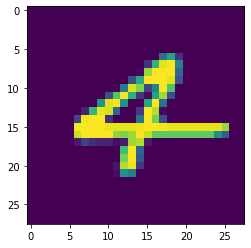

In [3]:
i = np.random.randint(0, x_train.shape[0])
image_to_display = x_train[i]
image_to_display = image_to_display.reshape([28, 28]).astype('float32')
print(y_train[i])
plt.imshow(image_to_display)

# ***Design the NN***

In [32]:
'''W = tf.Variable(tf.zeros(shape=(28*28,10), name="W"))
b = tf.Variable(tf.ones(shape=(10)), name="bias")

@tf.function
def forward(X):
  return tf.nn.softmax(W*X+b)

y_prediction = forward(image_to_display.reshape([28*28,1]))
print(y_prediction)


one_hot = tf.one_hot(label, depth=10)
#cross_entropy = lambda: tf.reduce_mean(-tf.reduce_sum(one_hot*tf.math.log(y_prediction)))
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
#train_step = opt.minimize(cross_entropy, [one_hot, y_prediction]).numpy()

@tf.function
def train_step(inputs, labels):
  with tf.GradientTape() as tape:
    predictions = forward(inputs)
    regularization_loss=tf.math.add_n(model.losses)
    pred_loss=loss_fn(labels, predictions)
    total_loss=pred_loss + regularization_loss

  gradients = tape.gradient(total_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))'''


tf.Tensor(
[[0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 ...
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]], shape=(784, 10), dtype=float32)


AttributeError: ignored

In [0]:
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (x_val, y_val)).shuffle(10000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [0]:
class MyModel(Model):
  def __init__(self, conv1=32, dense1=64, dropout=0.3, regular_l1=0.01, regular_l2=0.01):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(conv1, 3, activation='relu', 
                        kernel_regularizer=tf.keras.regularizers.l1(regular_l1),
                        activity_regularizer=tf.keras.regularizers.l2(regular_l2))
    self.flatten = Flatten()
    self.Dropout = Dropout(dropout)
    self.BatchNormalization = BatchNormalization()
    self.d1 = Dense(dense1, activation='relu', 
                        kernel_regularizer=tf.keras.regularizers.l1(regular_l1),
                        activity_regularizer=tf.keras.regularizers.l2(regular_l2))
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.Dropout(x)
    x = self.BatchNormalization(x)
    x = self.d1(x)
    x = self.Dropout(x)
    return self.d2(x)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Create an instance of the model
model = MyModel(conv1=32, dense1=128)

In [0]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def val_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  val_loss(t_loss)
  val_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [0]:
EPOCHS = 10

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()
  #test_loss.reset_states()
  #test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for val_images, val_labels in val_ds:
    val_step(val_images, val_labels)

  #for test_images, test_labels in test_ds:
  #  test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
  print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.21179233491420746, Accuracy: 93.82083129882812, Val Loss: 0.08507557958364487, Val Accuracy: 97.71666717529297


In [0]:
for test_images, test_labels in test_ds:
  test_step(test_images, test_labels)

template = 'Test Loss: {}, Test Accuracy: {}'
print(template.format(test_loss.result(),
                      test_accuracy.result() * 100))